# TELCO CHURN CASE STUDY
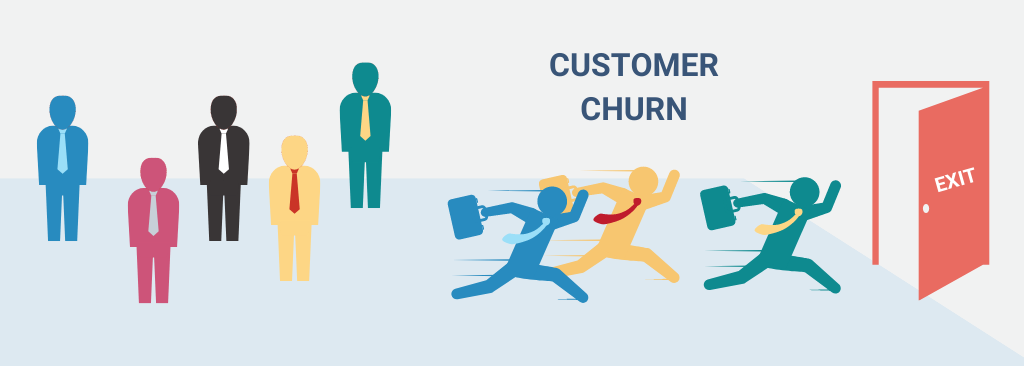

- Telco müşteri kaybı verileri, üçüncü çeyrekte Kaliforniya'daki 7043 müşteriye ev telefonu ve İnternet hizmetleri sağlayan hayali
bir telekom şirketi hakkında bilgi içerir. Hangi müşterilerin hizmetlerinden ayrıldığını, kaldığını veya hizmete kaydolduğunu
gösterir.

********************************
**DEĞİŞKENLER**
********************************
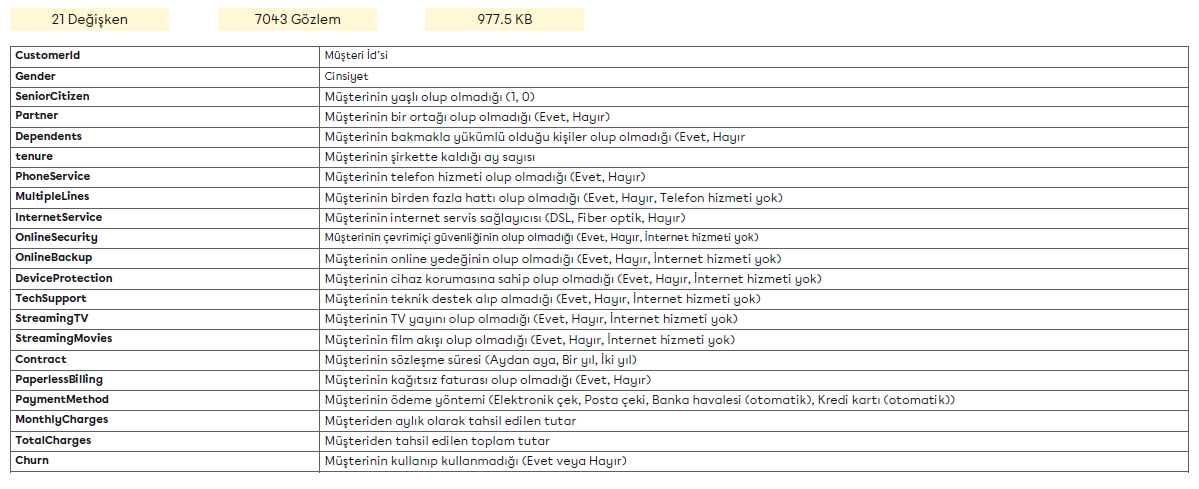

In [1]:
! pip install lazypredict

In [2]:
# Kütüphane yükleme işlemleri
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import  time
import scipy.stats as stats
from pandas.core.common import random_state


# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sympy import andre
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier



# Uyarıları kapatma
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.simplefilter(action="ignore")

## 1.Data Understanding

In [3]:
df = pd.read_csv('/kaggle/input/telcochurn/Telco-Customer-Churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(5))
    print('##################### Tail #####################')
    print(dataframe.tail(5))
    print('##################### NA #################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles ################')
    numeric_columns = dataframe.select_dtypes(include = ['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99]))

In [6]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
                     ...   
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
Length: 21, dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines Inter

### 1.1.Data Hazırlanması

In [7]:
# Kolan İsimleri Büyük Harflere Dönüştürülmesi
df.columns = [col.upper() for col in df.columns]
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [8]:
# TotalCharges Değişkenin Dönüştürülmei
df['TOTALCHARGES'] = pd.to_numeric(df['TOTALCHARGES'], errors= 'coerce')
df['TOTALCHARGES'].value_counts()

TOTALCHARGES
20.200      11
19.750       9
20.050       8
19.900       8
19.650       8
            ..
6849.400     1
692.350      1
130.150      1
3211.900     1
6844.500     1
Name: count, Length: 6530, dtype: int64

In [9]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes


### 1.2.Numerik ve kategorik değişkenlerin yakalanması

In [10]:
def grap_col_names(dataframe, cat_th = 10, car_th = 20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    
    print(f'Variables: {dataframe.shape[0]}')
    print(f'Columns: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return  cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)

Variables: 7043
Columns: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


### 1.2.Kategorik Değişkenlerin Analizi

In [12]:
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('********************************')

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        counts = dataframe[col_name].value_counts()
        ratios = 100 * counts / len(dataframe)


        # Count Plot
        ax = sns.countplot(x=col_name, data=dataframe, ax=axs[0], order=counts.index)
        axs[0].set_title("Frequency of " + col_name)
        axs[0].tick_params(axis='x', rotation=90)

        
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.01 * max(counts),
                    f'{ratios.iloc[i]:.2f}%',ha="center", va="bottom",rotation = 60)


        # Pie Chart
        wedges, texts, autotexts = axs[1].pie(x=counts, autopct='%1.1f%%', textprops=dict(color="w"))
        axs[1].set_title("Pie chart of " + col_name)
        # Add legend to pie chart
        axs[1].legend(wedges, counts.index,
                      title=col_name,
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))


        plt.tight_layout()
        plt.show()

        GENDER  Ratio
GENDER               
Male      3555 50.476
Female    3488 49.524
********************************


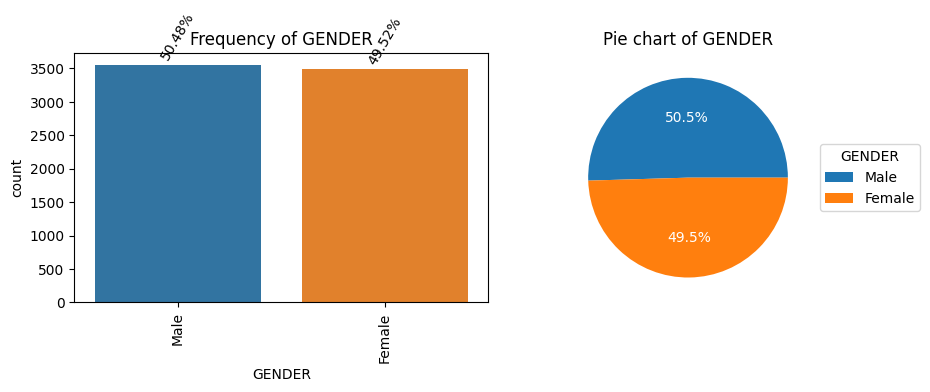

         PARTNER  Ratio
PARTNER                
No          3641 51.697
Yes         3402 48.303
********************************


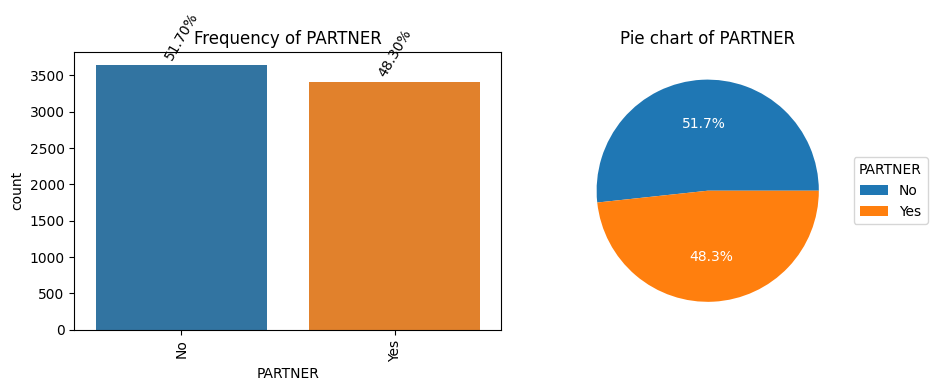

            DEPENDENTS  Ratio
DEPENDENTS                   
No                4933 70.041
Yes               2110 29.959
********************************


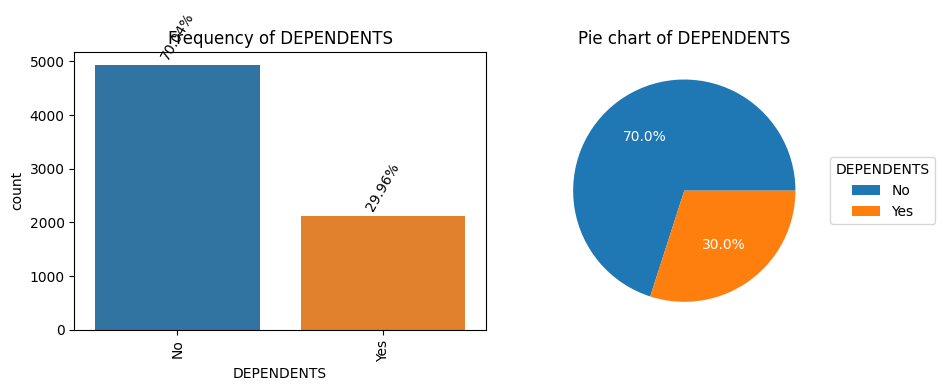

              PHONESERVICE  Ratio
PHONESERVICE                     
Yes                   6361 90.317
No                     682  9.683
********************************


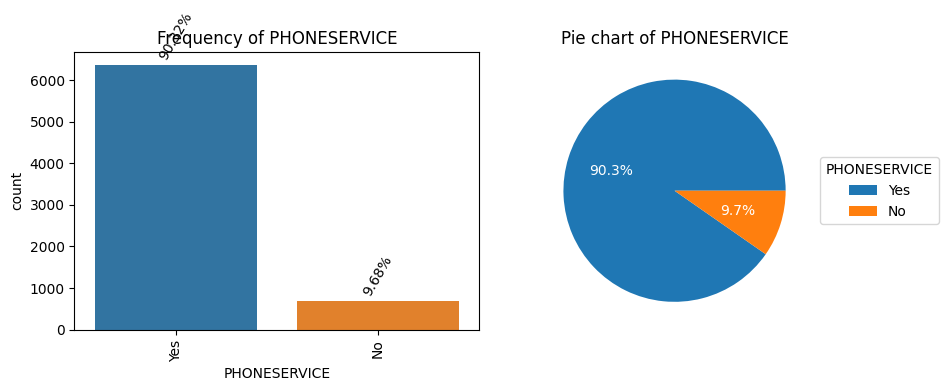

                  MULTIPLELINES  Ratio
MULTIPLELINES                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
********************************


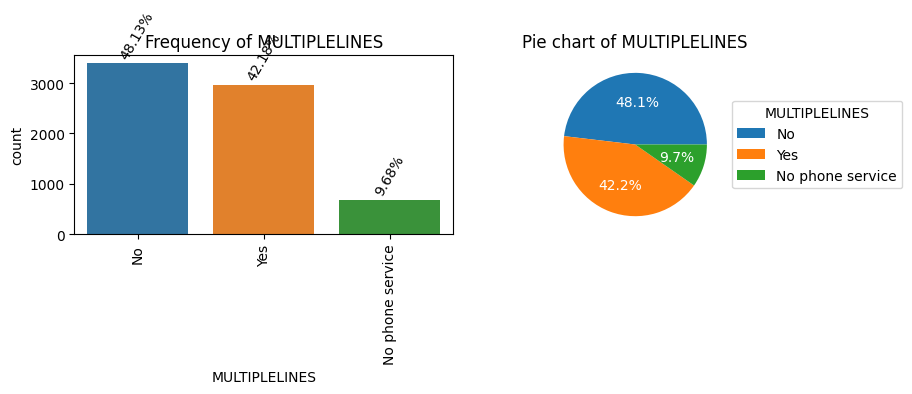

                 INTERNETSERVICE  Ratio
INTERNETSERVICE                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
********************************


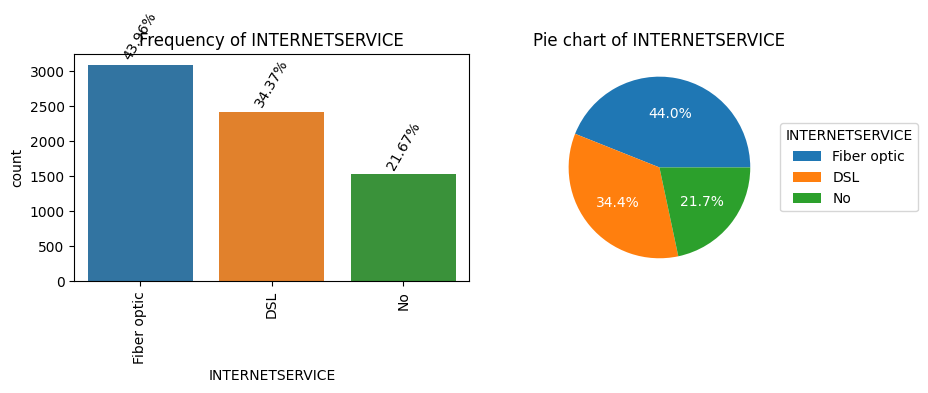

                     ONLINESECURITY  Ratio
ONLINESECURITY                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
********************************


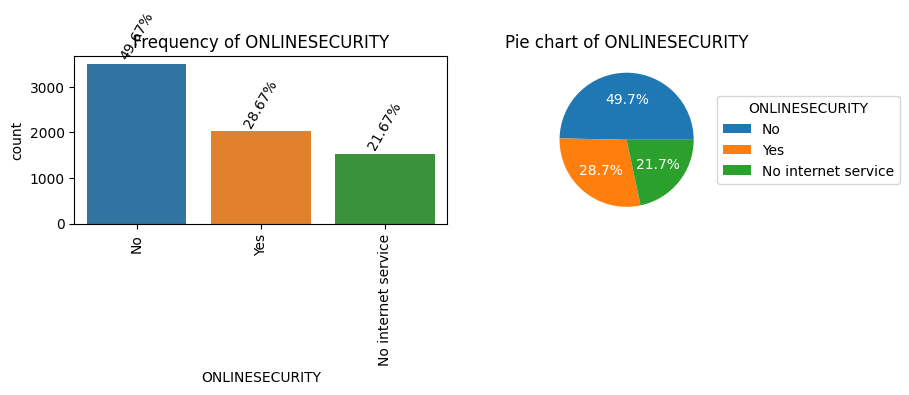

                     ONLINEBACKUP  Ratio
ONLINEBACKUP                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
********************************


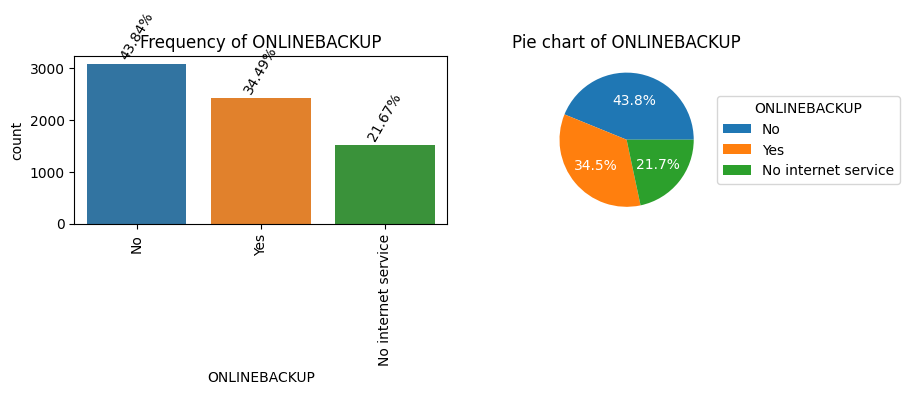

                     DEVICEPROTECTION  Ratio
DEVICEPROTECTION                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
********************************


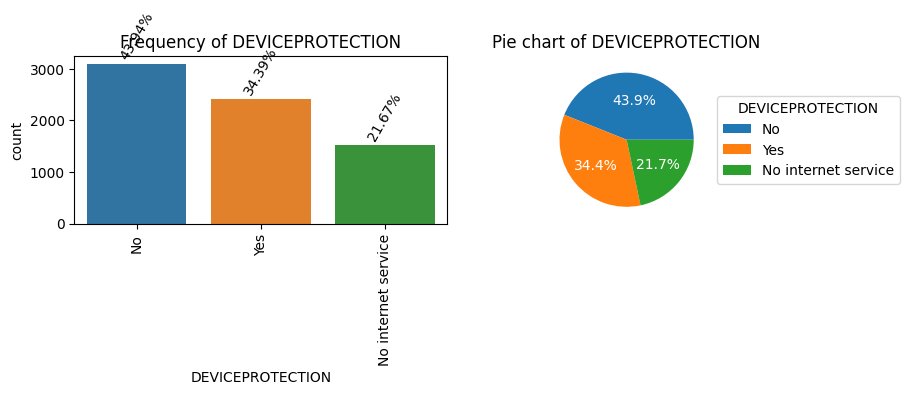

                     TECHSUPPORT  Ratio
TECHSUPPORT                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
********************************


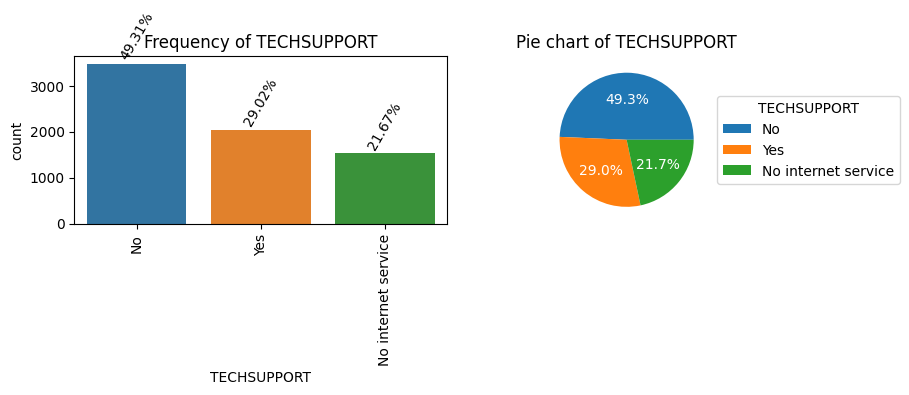

                     STREAMINGTV  Ratio
STREAMINGTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
********************************


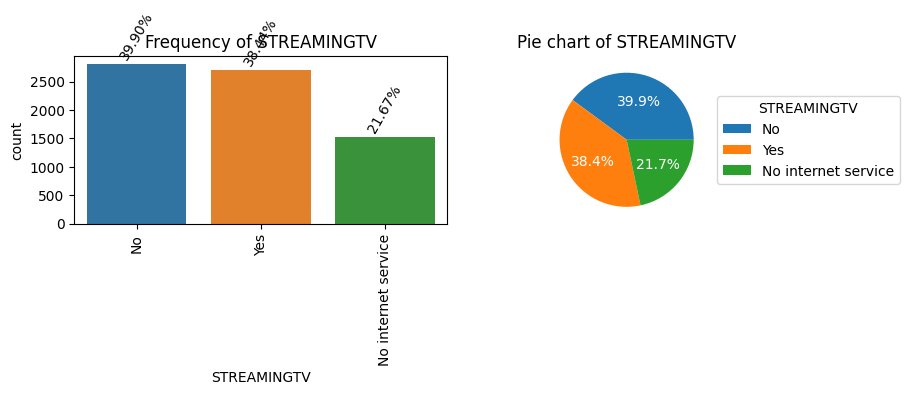

                     STREAMINGMOVIES  Ratio
STREAMINGMOVIES                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
********************************


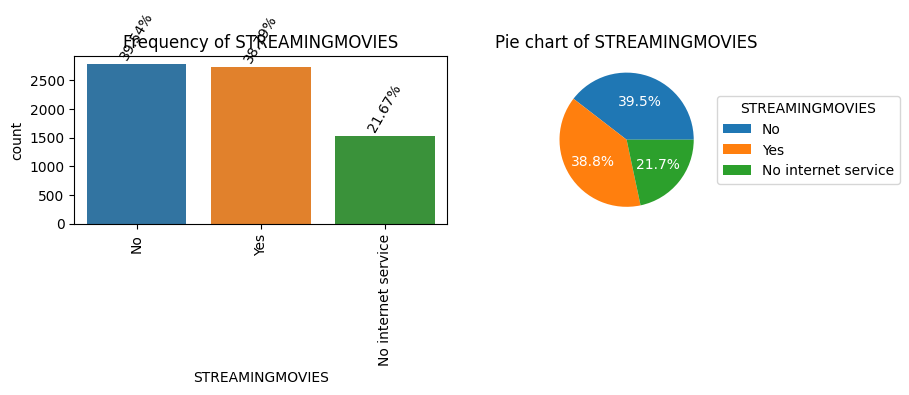

                CONTRACT  Ratio
CONTRACT                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
********************************


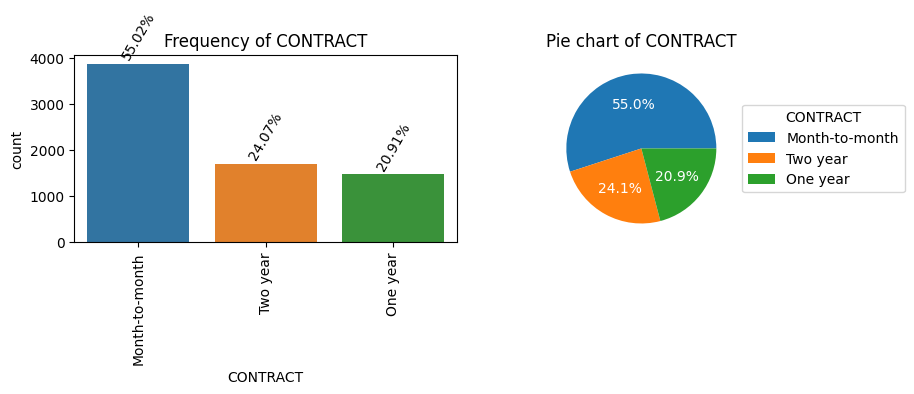

                  PAPERLESSBILLING  Ratio
PAPERLESSBILLING                         
Yes                           4171 59.222
No                            2872 40.778
********************************


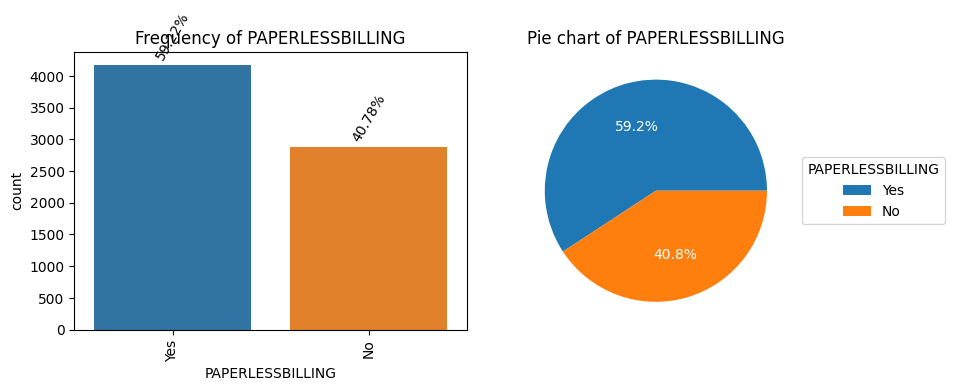

                           PAYMENTMETHOD  Ratio
PAYMENTMETHOD                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
********************************


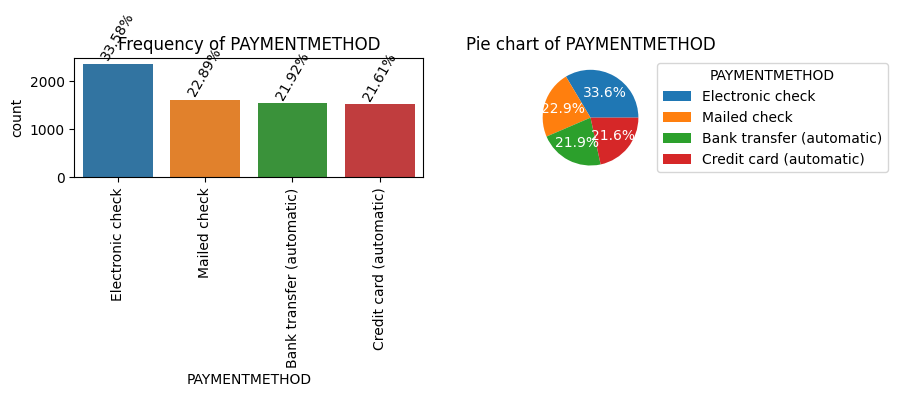

       CHURN  Ratio
CHURN              
No      5174 73.463
Yes     1869 26.537
********************************


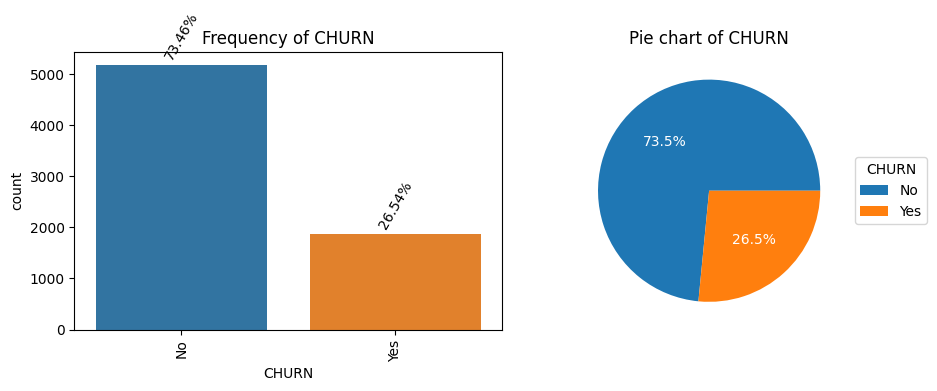

               SENIORCITIZEN  Ratio
SENIORCITIZEN                      
0                       5901 83.785
1                       1142 16.215
********************************


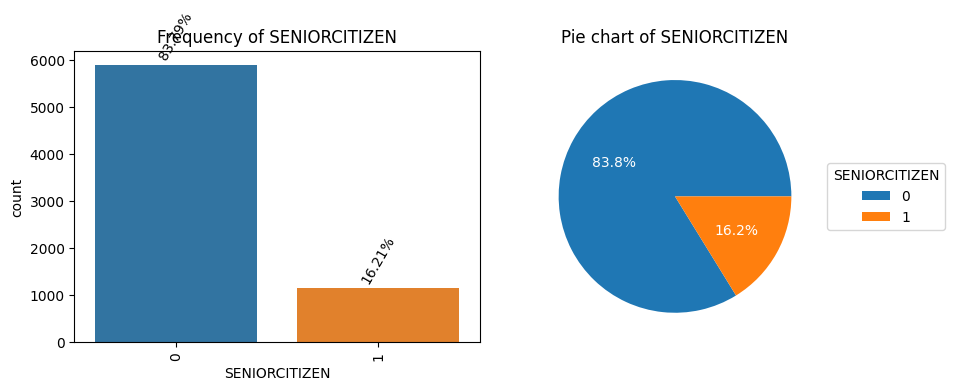

In [13]:
for col in cat_cols:
    cat_summary(df, col, plot = True)

### 1.3.Numeric Değişkenlerin Analizi

In [14]:
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.01, 0.05, 0.50, 0.95, 0.99]
   
    print(dataframe[numerical_col].describe(quantiles).T)
    print('********************************************')

    if plot:
        fig, axs = plt.subplots(2,2, figsize = (12, 10))


        # Histogram
        plt.subplot(2,2,1)
        dataframe[numerical_col].hist(bins = 50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + 'Distribution')


        # Density Plot
        plt.subplot(2, 2, 3)
        sns.kdeplot(dataframe[numerical_col], shade=True)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Density')


        # Boxplot
        plt.subplot(2,2,2)
        sns.boxplot(y=numerical_col, data = dataframe)
        plt.title('Boxplot of ' + numerical_col)
        plt.xticks(rotation = 90)


        # QQ Plot
        plt.subplot(2,2,4)
        stats.probplot(dataframe[numerical_col], dist = 'norm', plot = plt)
        plt.title(numerical_col + 'QQ Plot')


        plt.tight_layout
        plt.show()

In [15]:
num_cols = [col for col in num_cols if col != 'CUSTOMERID']

count   7043.000
mean      32.371
std       24.559
min        0.000
1%         1.000
5%         1.000
50%       29.000
95%       72.000
99%       72.000
max       72.000
Name: TENURE, dtype: float64
********************************************


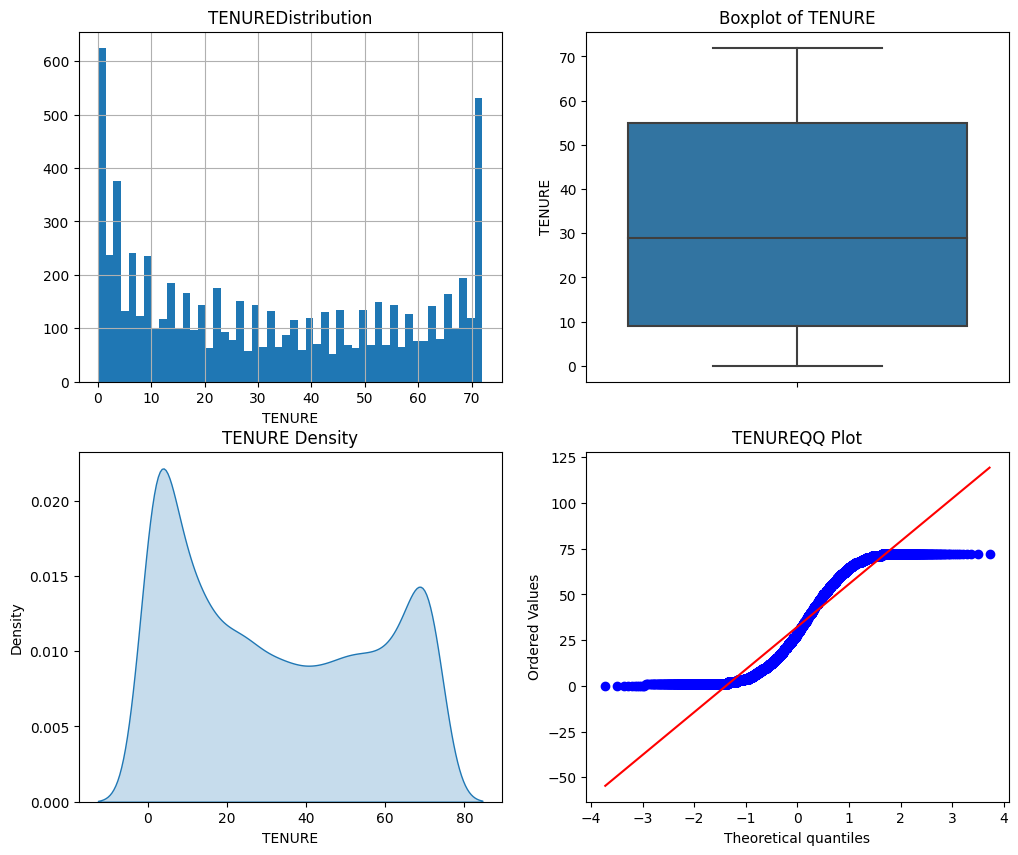

count   7043.000
mean      64.762
std       30.090
min       18.250
1%        19.200
5%        19.650
50%       70.350
95%      107.400
99%      114.729
max      118.750
Name: MONTHLYCHARGES, dtype: float64
********************************************


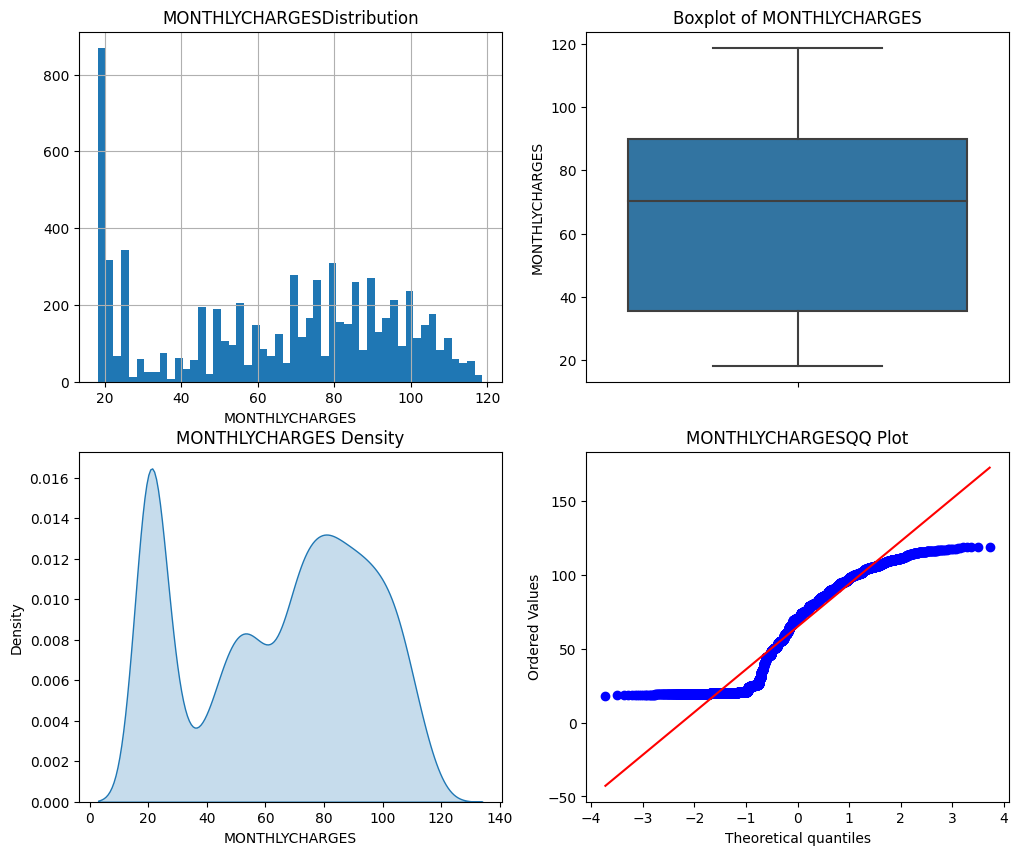

count   7032.000
mean    2283.300
std     2266.771
min       18.800
1%        19.900
5%        49.605
50%     1397.475
95%     6923.590
99%     8039.883
max     8684.800
Name: TOTALCHARGES, dtype: float64
********************************************


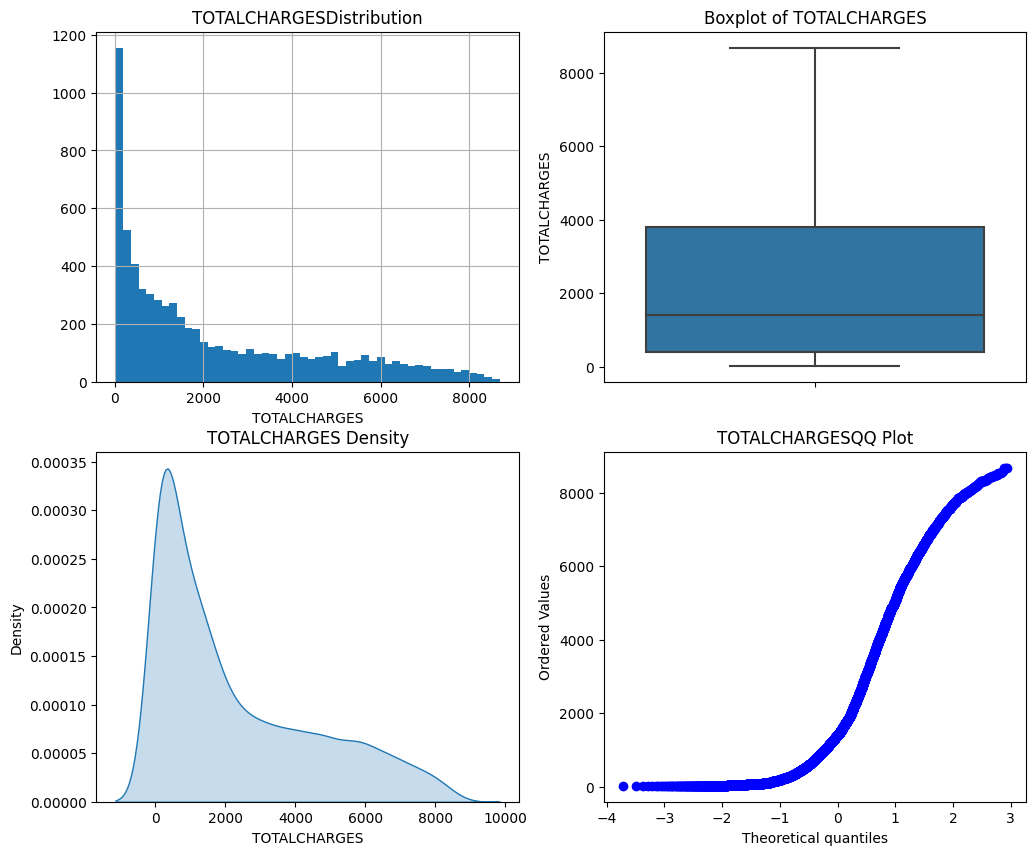

In [16]:
for col in num_cols:
    num_summary(df, col, plot = True)

### 1.4.Numerik Değişkenlerin Targete Göre Analizi

In [17]:
def target_summary_with_num(dataframe, target, numerical_col, plot = False):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}), end= "\n\n")


    if plot:
        fig, axs = plt.subplots(2,2, figsize = (12, 10))


    # Histogram
    plt.subplot(2,2,1)
    dataframe[numerical_col].hist(bins = 50)
    plt.xlabel(numerical_col)
    plt.title(numerical_col + 'Distribution')


    # Boxplot
    plt.subplot(2,2,2)
    sns.boxplot(y=numerical_col, data = dataframe)
    plt.title('Boxplot of ' + numerical_col)
    plt.xticks(rotation = 90)


    plt.tight_layout
    plt.show()

       TENURE
CHURN        
No     37.570
Yes    17.979



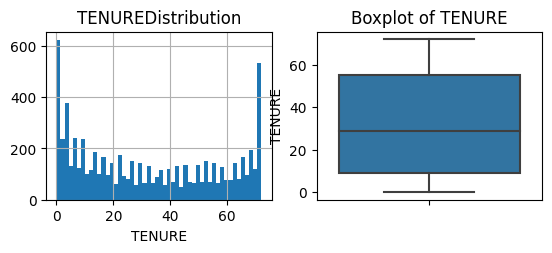

       MONTHLYCHARGES
CHURN                
No             61.265
Yes            74.441



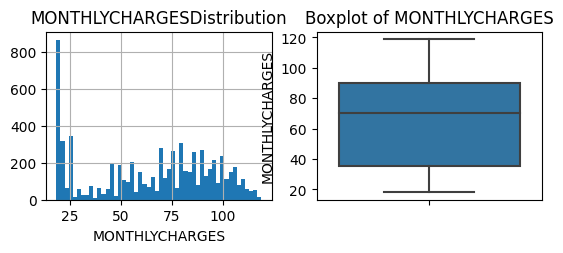

       TOTALCHARGES
CHURN              
No         2555.344
Yes        1531.796



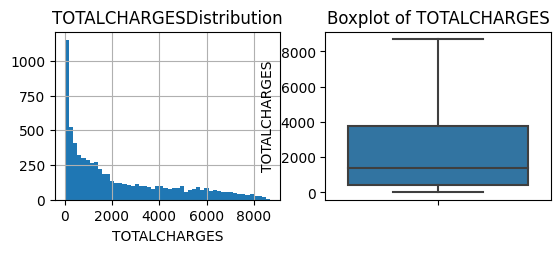

In [18]:
for col in num_cols:
    target_summary_with_num(df, 'CHURN', col)

### 1.5.Outlier Analizi

In [19]:
def outlier_thresholds(dataframe, col_name, q1 =0.10, q3= 0.90):

    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)

    interquantile_range = quantile3 - quantile1

    up_limit = quantile3 + interquantile_range * 1.5
    low_limit = quantile1 - interquantile_range * 1.5

    return low_limit, up_limit

In [20]:
for col in num_cols:
    print(col, outlier_thresholds(df,col))

TENURE (-98.5, 169.5)
MONTHLYCHARGES (-103.77499999999999, 226.42499999999998)
TOTALCHARGES (-8753.460000000001, 14814.700000000003)


In [21]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False

In [22]:
for col in num_cols:
    print(col, check_outlier(df,col))

TENURE False
MONTHLYCHARGES False
TOTALCHARGES False


### 1.6.Missing Value

In [23]:
def missing_values_table(dataframe, na_name = False):
    
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
   
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys = ['n_miss', 'ratio'])
    print(missing_df, end = '\n')



    if na_name:
        return na_columns

In [24]:
missing_values_table(df)

              n_miss  ratio
TOTALCHARGES      11  0.160


In [25]:
# TotalCharges değişkenin eksik değerleri mean ile doldurulması
df['TOTALCHARGES'] = df['TOTALCHARGES'].fillna(df['TOTALCHARGES'].mean())

In [26]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### 1.7.Numeric değişkenlere göre korelasyonun bakılması

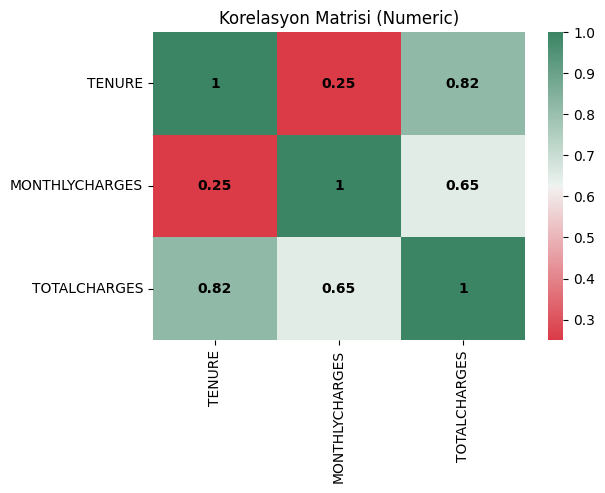

In [27]:
# Numeric değişkenlerin korelasyon analizlerine bakılması
correlation_matrix = df[num_cols].corr().round(2)
plt.figure(figsize=(6, 4))
sns.heatmap(data=correlation_matrix, annot=True, annot_kws={"size": 10, "weight": "bold", "color": "black"}, cmap=sns.diverging_palette(10, 150, as_cmap=True))

plt.title("Korelasyon Matrisi (Numeric)")
plt.xticks(rotation=90)
plt.show()

## 2.Data Preprocessing

### 2.1.Encoding (Dummies)

In [28]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)
dff.head()

,SENIORCITIZEN,TENURE,MONTHLYCHARGES,TOTALCHARGES,GENDER_Male,PARTNER_Yes,DEPENDENTS_Yes,PHONESERVICE_Yes,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAPERLESSBILLING_Yes,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,CHURN_Yes
0,0,1,29.850,29.850,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
1,0,34,56.950,1889.500,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2,0,2,53.850,108.150,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
3,0,45,42.300,1840.750,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
4,0,2,70.700,151.650,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True


### 2.2.MinMax ile Scaler Edilmesi

In [29]:
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)

In [30]:
dff.head()

,SENIORCITIZEN,TENURE,MONTHLYCHARGES,TOTALCHARGES,GENDER_Male,PARTNER_Yes,DEPENDENTS_Yes,PHONESERVICE_Yes,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAPERLESSBILLING_Yes,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,CHURN_Yes
0,0.000,0.014,0.115,0.001,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000
1,0.000,0.472,0.385,0.216,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
2,0.000,0.028,0.354,0.010,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000
3,0.000,0.625,0.239,0.210,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.028,0.522,0.015,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000


## 3.Base Model

### 3.1.Base Model Kurulumu

In [31]:
# Hedef değişken (target) ve özellikleri (features) ayırma
y = dff['CHURN_Yes']  # Hedef değişken
X = dff.drop('CHURN_Yes', axis=1) # Özellikler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [32]:
clf = LazyClassifier(verbose = 0, ignore_warnings=True, custom_metric=None) # LightGBM hariç diğer modelleri seçin.# LazyClassifier sınıfından bir nesne oluşturulması
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # LazyClassifier nesnesinin fit edilmesi

100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

[LightGBM] [Info] Number of positive: 1490, number of negative: 4144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264466 -> initscore=-1.022885
[LightGBM] [Info] Start training from score -1.022885


In [33]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.729,0.745,0.745,0.743,0.030
NearestCentroid,0.699,0.742,0.742,0.716,0.089
GaussianNB,0.669,0.730,0.730,0.687,0.030
QuadraticDiscriminantAnalysis,0.701,0.725,0.725,0.718,0.102
LogisticRegression,0.803,0.714,0.714,0.794,0.187
...,...,...,...,...,...
DecisionTreeClassifier,0.710,0.636,0.636,0.712,0.090
ExtraTreeClassifier,0.722,0.635,0.635,0.718,0.027
Perceptron,0.713,0.629,0.629,0.711,0.132


### 3.2.Base Model Hyperparameter Optimizasyonu

In [34]:
adaboost_model = AdaBoostClassifier(random_state=17)

In [35]:
adaboost_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 17}

In [36]:
adaboost_params = {'n_estimators': [50, 200, 500],
                   'learning_rate': [0.01, 0.1, 0.5, 1]}

In [37]:
adaboost_model_best_grid = GridSearchCV(adaboost_model, adaboost_params, cv =5, n_jobs=-1, verbose=True).fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [38]:
adaboost_model_best_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [39]:
adaboost_model_base = adaboost_model.set_params(**adaboost_model_best_grid.best_params_, random_state = 17).fit(X,y)

In [40]:
cv_result = cross_validate(adaboost_model_base, X,y, cv =5, scoring=['accuracy', 'f1', 'roc_auc'])

In [41]:
cv_result['test_accuracy'].mean()

0.8043450383895735

In [42]:
cv_result['test_f1'].mean()

0.5888497525712356

In [43]:
cv_result['test_roc_auc'].mean()

0.8475075615177534

## 4.Feature Engineering

In [44]:
df.columns

Index(['CUSTOMERID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
       'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
       'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING',
       'PAYMENTMETHOD', 'MONTHLYCHARGES', 'TOTALCHARGES', 'CHURN'],
      dtype='object')

In [45]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes


### 4.1.Yeni Değişkenleri Oluşturulması ve Analizi

In [46]:
# 1. Hizmet Sayısı
services = ["PHONESERVICE","INTERNETSERVICE","ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]
df['TOTALSERVOCES'] = df[services].apply(lambda x: np.sum(x != 'No'), axis=1)

# 2. Streaming Hizmet Sayısı
streaming_services = ["STREAMINGTV","STREAMINGMOVIES"]
df['TOTALSTREAMINGSERVICES'] = df[streaming_services].apply(lambda x: np.sum(x == 'Yes'), axis=1)

# 3. Güvenlik Hizmetleri Sayısı
security_services = ["ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT"]
df['TOTALSECURITYSERVICES'] = df[security_services].apply(lambda x: np.sum(x == 'Yes'), axis=1)

# 4. Aile Durumu (Partner ve Dependents birleşimi)
df['FAMILYSTATUS'] = df.apply(lambda x: 'Single' if (x['PARTNER'] == 'No' and x['DEPENDENTS'] =='No')
else ('Family' if (x['PARTNER'] == 'Yes' and x['DEPENDENTS'] == 'Yes')
      else 'Partial'), axis=1)

# 5. Tenure Grupları
df['TENUREGROUP'] = pd.qcut(df['TENURE'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 6. Aylık Ücret Grupları
df['MONTHLYCHARGESGROUP'] = pd.qcut(df['MONTHLYCHARGES'], q=3, labels=['Low', 'Medium', 'High'])

# 7. Dijital Eğilim Skoru
df['DIGITALSCORE'] = df.apply(lambda x:
                              (1 if x['PAPERLESSBILLING'] == 'Yes' else 0) +
                              (1 if x['PAYMENTMETHOD'] == 'Electronic check' else 0) +
                              (1 if x['ONLINEBACKUP'] == 'Yes' else 0) +
                              (1 if x['STREAMINGTV'] == 'Yes' else 0) +
                              (1 if x['STREAMINGMOVIES'] == 'Yes' else 0), axis=1)

# 8. Hizmet Süresi / Yaş Oranı (Sadece SeniorCitizen için)
df['TENURESENIORRATIO'] = df.apply(lambda x: x['TENURE'] / 60 if x['SENIORCITIZEN'] == 1 else x['TENURE'] / 30, axis=1)

In [47]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,TOTALSERVOCES,TOTALSTREAMINGSERVICES,TOTALSECURITYSERVICES,FAMILYSTATUS,TENUREGROUP,MONTHLYCHARGESGROUP,DIGITALSCORE,TENURESENIORRATIO
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,No,2,0,1,Partial,Q1,Low,3,0.033
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,No,4,0,2,Single,Q3,Medium,0,1.133
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes,4,0,2,Single,Q1,Medium,2,0.067
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,No,4,0,3,Single,Q3,Low,0,1.500
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes,2,0,0,Single,Q1,Medium,2,0.067


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CUSTOMERID              7043 non-null   object  
 1   GENDER                  7043 non-null   object  
 2   SENIORCITIZEN           7043 non-null   int64   
 3   PARTNER                 7043 non-null   object  
 4   DEPENDENTS              7043 non-null   object  
 5   TENURE                  7043 non-null   int64   
 6   PHONESERVICE            7043 non-null   object  
 7   MULTIPLELINES           7043 non-null   object  
 8   INTERNETSERVICE         7043 non-null   object  
 9   ONLINESECURITY          7043 non-null   object  
 10  ONLINEBACKUP            7043 non-null   object  
 11  DEVICEPROTECTION        7043 non-null   object  
 12  TECHSUPPORT             7043 non-null   object  
 13  STREAMINGTV             7043 non-null   object  
 14  STREAMINGMOVIES         

In [49]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)

Variables: 7043
Columns: 29
cat_cols: 24
num_cols: 4
cat_but_car: 1
num_but_cat: 7


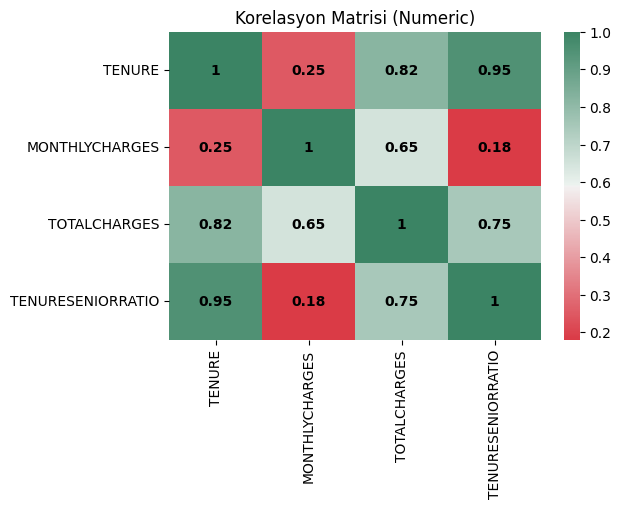

In [50]:
# Numeric değişkenlerin korelasyon analizlerine bakılması
correlation_matrix = df[num_cols].corr().round(2)
plt.figure(figsize=(6, 4))
sns.heatmap(data=correlation_matrix, annot=True, annot_kws={"size": 10, "weight": "bold", "color": "black"}, cmap=sns.diverging_palette(10, 150, as_cmap=True))

plt.title("Korelasyon Matrisi (Numeric)")
plt.xticks(rotation=90)
plt.show()

### 4.2.Endcoding İşlemleri

In [51]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df,cat_cols, drop_first=True)

In [52]:
df.head()

,CUSTOMERID,TENURE,MONTHLYCHARGES,TOTALCHARGES,TENURESENIORRATIO,GENDER_Male,PARTNER_Yes,DEPENDENTS_Yes,PHONESERVICE_Yes,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAPERLESSBILLING_Yes,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,CHURN_Yes,FAMILYSTATUS_Partial,FAMILYSTATUS_Single,SENIORCITIZEN_1,TOTALSERVOCES_2,TOTALSERVOCES_3,TOTALSERVOCES_4,TOTALSERVOCES_5,TOTALSERVOCES_6,TOTALSERVOCES_7,TOTALSERVOCES_8,TOTALSTREAMINGSERVICES_1,TOTALSTREAMINGSERVICES_2,TOTALSECURITYSERVICES_1,TOTALSECURITYSERVICES_2,TOTALSECURITYSERVICES_3,TOTALSECURITYSERVICES_4,TENUREGROUP_Q2,TENUREGROUP_Q3,TENUREGROUP_Q4,MONTHLYCHARGESGROUP_Medium,MONTHLYCHARGESGROUP_High,DIGITALSCORE_1,DIGITALSCORE_2,DIGITALSCORE_3,DIGITALSCORE_4,DIGITALSCORE_5
0,7590-VHVEG,1,29.850,29.850,0.033,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
1,5575-GNVDE,34,56.950,1889.500,1.133,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False
2,3668-QPYBK,2,53.850,108.150,0.067,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False
3,7795-CFOCW,45,42.300,1840.750,1.500,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,9237-HQITU,2,70.700,151.650,0.067,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False


### 4.3.Standartlaştırma İşlemi

In [53]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [54]:
df.head()

,CUSTOMERID,TENURE,MONTHLYCHARGES,TOTALCHARGES,TENURESENIORRATIO,GENDER_Male,PARTNER_Yes,DEPENDENTS_Yes,PHONESERVICE_Yes,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAPERLESSBILLING_Yes,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,CHURN_Yes,FAMILYSTATUS_Partial,FAMILYSTATUS_Single,SENIORCITIZEN_1,TOTALSERVOCES_2,TOTALSERVOCES_3,TOTALSERVOCES_4,TOTALSERVOCES_5,TOTALSERVOCES_6,TOTALSERVOCES_7,TOTALSERVOCES_8,TOTALSTREAMINGSERVICES_1,TOTALSTREAMINGSERVICES_2,TOTALSECURITYSERVICES_1,TOTALSECURITYSERVICES_2,TOTALSECURITYSERVICES_3,TOTALSECURITYSERVICES_4,TENUREGROUP_Q2,TENUREGROUP_Q3,TENUREGROUP_Q4,MONTHLYCHARGESGROUP_Medium,MONTHLYCHARGESGROUP_High,DIGITALSCORE_1,DIGITALSCORE_2,DIGITALSCORE_3,DIGITALSCORE_4,DIGITALSCORE_5
0,7590-VHVEG,0.014,0.115,0.001,0.014,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
1,5575-GNVDE,0.472,0.385,0.216,0.472,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False
2,3668-QPYBK,0.028,0.354,0.010,0.028,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False
3,7795-CFOCW,0.625,0.239,0.210,0.625,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,9237-HQITU,0.028,0.522,0.015,0.028,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False


In [55]:
df.columns

Index(['CUSTOMERID', 'TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES',
       'TENURESENIORRATIO', 'GENDER_Male', 'PARTNER_Yes', 'DEPENDENTS_Yes',
       'PHONESERVICE_Yes', 'MULTIPLELINES_No phone service',
       'MULTIPLELINES_Yes', 'INTERNETSERVICE_Fiber optic',
       'INTERNETSERVICE_No', 'ONLINESECURITY_No internet service',
       'ONLINESECURITY_Yes', 'ONLINEBACKUP_No internet service',
       'ONLINEBACKUP_Yes', 'DEVICEPROTECTION_No internet service',
       'DEVICEPROTECTION_Yes', 'TECHSUPPORT_No internet service',
       'TECHSUPPORT_Yes', 'STREAMINGTV_No internet service', 'STREAMINGTV_Yes',
       'STREAMINGMOVIES_No internet service', 'STREAMINGMOVIES_Yes',
       'CONTRACT_One year', 'CONTRACT_Two year', 'PAPERLESSBILLING_Yes',
       'PAYMENTMETHOD_Credit card (automatic)',
       'PAYMENTMETHOD_Electronic check', 'PAYMENTMETHOD_Mailed check',
       'CHURN_Yes', 'FAMILYSTATUS_Partial', 'FAMILYSTATUS_Single',
       'SENIORCITIZEN_1', 'TOTALSERVOCES_2', 'TOTALSERVOCES_3',
  

## 5.Gelişmiş Model

In [56]:
y = df['CHURN_Yes']
X = df.drop(['CUSTOMERID','CHURN_Yes'], axis = 1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=17)

### 5.1.En Doğru Model Seçimi (LazyClassifier)

In [58]:
clf = LazyClassifier(verbose = 0, ignore_warnings=True, custom_metric=None) # LightGBM hariç diğer modelleri seçin.# LazyClassifier sınıfından bir nesne oluşturulması
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # LazyClassifier nesnesinin fit edilmesi

100%|██████████| 29/29 [00:08<00:00,  3.39it/s]

[LightGBM] [Info] Number of positive: 1490, number of negative: 4144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264466 -> initscore=-1.022885
[LightGBM] [Info] Start training from score -1.022885


In [59]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.759,0.734,0.734,0.767,0.020
GaussianNB,0.733,0.727,0.727,0.745,0.021
AdaBoostClassifier,0.800,0.706,0.706,0.790,0.333
LinearDiscriminantAnalysis,0.797,0.702,0.702,0.787,0.021
NearestCentroid,0.669,0.702,0.702,0.687,0.044
...,...,...,...,...,...
SVC,0.795,0.660,0.660,0.769,1.024
NuSVC,0.786,0.656,0.656,0.763,1.015
ExtraTreeClassifier,0.710,0.622,0.622,0.707,0.021


#### 5.2 Gelişmiş Modeli Hiperparametre Optimizasyonu

In [60]:
final_model = LogisticRegression(random_state=17)

In [61]:
final_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 17,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [62]:
cv_result = cross_validate(final_model, X,y, cv =5, scoring=['accuracy', 'f1', 'roc_auc'])

In [63]:
cv_result['test_accuracy'].mean()

0.8032093804438997

In [64]:
cv_result['test_f1'].mean()

0.5851938219587909

In [65]:
cv_result['test_roc_auc'].mean()

0.8454959896512108